# Analyze Paleo Simulations

In [1]:
import xarray as xr
from glob import glob
import pylab as plt
import pandas as pd
import os
from dask.diagnostics import ProgressBar
import dask
import re
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.lines as mlines
import cartopy.crs as ccrs
from typing import Union
import cftime
from tqdm.auto import tqdm

from pypism.utils import qgis2cmap
from pism_ragis.analysis import sensitivity_analysis
from pism_ragis.processing import convert_netcdf_to_dataframe, check_paleo_file, copy_file
from pism_ragis.stats import run_stats

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [38]:
fontsize = 8
lw = 0.65
markersize = 1
params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
    }

plt.rcParams.update(params)


## Grid Resolution

In [39]:
grid_res = 9000

## Data Path

In [40]:
data_dir = Path("/mnt/storstrommen/layers-v2/data/pism/")

In [41]:
exp = {"Experiment": "climate-calving",
       "proj_dir": Path("2024_01_climate_calving"),
       "snap_dir": "snap",
       "spatial_dir": "spatial",
       "spatial_tmp_dir": Path("2024_01_climate_calving_tmp"),
       "scalar_dir": "scalar",
       "state_dir": "state",
       "fig_dir": "figures",
        "lhs": "gris_paleo_climate_calving_w_posterior_lhs_20",
        "DEM": "GRIMP"
    }

In [42]:
fig_path = data_dir / exp["proj_dir"] / exp["fig_dir"]
fig_path.mkdir(exist_ok=True)

In [43]:
def preprocess_nc(ds: xr.DataArray) -> xr.DataArray:
    """
    Preprocessing of ensemble

    Tries to get "id" from filename and add it as a new
    dimension used to concatenate the files
    """
    m_id_re = re.search("id_(.+?)_", ds.encoding["source"])
    assert m_id_re is not None
    m_id: Union[str, int]
    m_id = int(m_id_re.group(1))

    ds["id"] = m_id

    if "nv" in ds.sizes:
        ds = ds.mean(dim="nv")
    return ds.drop_duplicates(dim="time")

## Scalar fields

In [44]:
scalar_path = data_dir / exp["proj_dir"] / exp["scalar_dir"]
scalar_processed_path = data_dir / exp["proj_dir"] / (exp["scalar_dir"] + "_processed")
scalar_files = sorted(scalar_path.glob(f"*{grid_res}m*.nc"))

for scalar_file in tqdm(scalar_files):
    if check_paleo_file:
        copy_file(scalar_file, scalar_processed_path)
scalar_processed_files = sorted(scalar_processed_path.glob("*0.nc"))

  0%|          | 0/20 [00:00<?, ?it/s]

In [45]:
scalar_ds = xr.open_mfdataset(scalar_processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True).chunk(dict(id=-1))

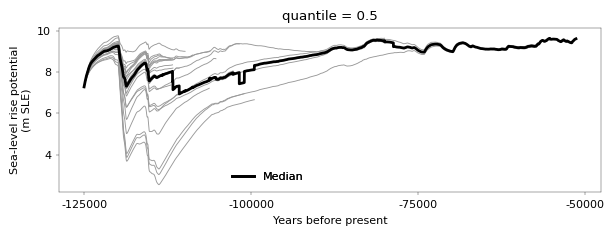

In [17]:
plot_var = "sea_level_rise_potential" 

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
scalar_ds[plot_var].plot.line(x="time", color="0.6", ax=ax, add_legend=False)

q_16 = scalar_ds[plot_var].quantile(0.16, dim="id")
q_50 = scalar_ds[plot_var].quantile(0.50, dim="id")
q_84 = scalar_ds[plot_var].quantile(0.84, dim="id")
# ax.fill_between(q_50["time"], q_16, q_84, color="b")
q_50.plot.line(x="time", color="k", lw=2, ax=ax, label="median", add_legend=False)
median_line = mlines.Line2D(
    [], [], color="k", linewidth=2, label="Median"
    )
legend = ax.legend(handles=[median_line], loc="lower left", bbox_to_anchor=(0.3, 0.0))
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
ax.add_artist(legend)

ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(fig_path / f"{plot_var}_paleo-ensemble-{grid_res}m.pdf")

In [47]:
scalar_df = scalar_ds.to_dataframe().reset_index()

ConversionError: Failed to convert value(s) to axis units: 0          -124999-01-01 00:00:00
1          -124999-01-01 00:00:00
2          -124999-01-01 00:00:00
3          -124999-01-01 00:00:00
4          -124999-01-01 00:00:00
                    ...          
1555015       0001-01-01 00:00:00
1555016       0001-01-01 00:00:00
1555017       0001-01-01 00:00:00
1555018       0001-01-01 00:00:00
1555019       0001-01-01 00:00:00
Name: x, Length: 1555020, dtype: object

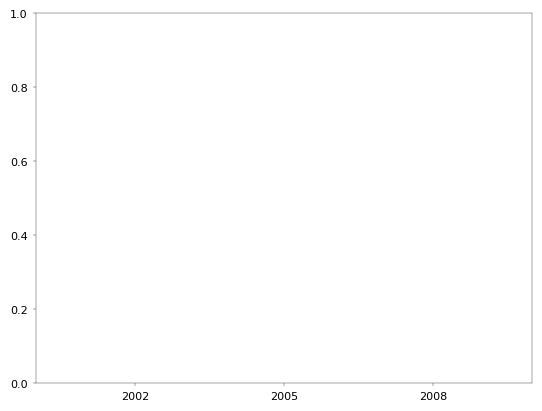

In [48]:
sns.lineplot(data=scalar_df, x="time", y=plot_var, estimator=None)

## Spatial fields

In [ ]:
spatial_path = data_dir / exp["proj_dir"] / exp["spatial_dir"]
spatial_tmp_path = data_dir / exp["spatial_tmp_dir"]
spatial_processed_path = data_dir / exp["proj_dir"] / (exp["spatial_dir"] + "_processed")
spatial_processed_path.mkdir(parents=True, exist_ok=True)
spatial_files = sorted(spatial_tmp_path.glob(f"ex_*{grid_res}m*.nc"))

for spatial_file in tqdm(spatial_files):
    if check_paleo_file:
        copy_file(spatial_file, spatial_processed_path)
spatial_processed_files = sorted(spatial_processed_path.glob("ex_*0.nc"))

In [ ]:
spatial_processed_files = sorted(spatial_processed_path.glob("ex_*0.nc"))

In [ ]:
spatial_ds = xr.open_mfdataset(spatial_processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True)

In [ ]:
speed_cmap = qgis2cmap("/home/andy/base/pypism/tests/data/test_qgis_colorramp.txt")

In [ ]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
s = spatial_ds.sel(time=cftime.DatetimeNoLeap(-120000, 1, 1), method="nearest")["velsurf_mag"].median(dim="id").load()
f = s.plot(vmin=10, vmax=1500,
           cmap=speed_cmap,
           cbar_kwargs={"label": "Speed (m/yr)"},
           transform=crs,                                                                                                   
           subplot_kws={"projection": crs})
f.axes.coastlines(linewidth=0.25, resolution="10m")
f.axes.set_extent([-60, -30, 58, 85])

In [ ]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
s = spatial_ds.sel(time=cftime.DatetimeNoLeap(-120000, 1, 1), method="nearest")["velsurf_mag"].load()
f = s.plot(vmin=10, vmax=1500,
           cmap=speed_cmap,
           col="id", col_wrap=4,                                                            
           transform=crs,                                                                                                   
           subplot_kws={"projection": crs})
for f_ax in f.axs.flat:
    f_ax.coastlines(linewidth=0.25, resolution="10m")
    f_ax.set_extent([-60, -30, 58, 85])

In [ ]:
sorted(spatial_ds.id)

In [ ]:
state_path = data_dir / exp["proj_dir"] / exp["state_dir"]
state_files = sorted(state_path.glob(f"*{grid_res}m*.nc"))

snap_path = data_dir / exp["proj_dir"] / exp["snap_dir"]
snap_files = sorted(snap_path.glob(f"*{grid_res}m*.nc"))
snap_processed_path = data_dir / exp["proj_dir"] / "snap_processed"
snap_processed_files = sorted(sorted(snap_processed_path.glob("save*.nc")))

In [ ]:
spatial_processed_files = sorted(spatial_processed_path.glob("ex_*0.nc"))

In [ ]:
scalar_ds = xr.open_mfdataset(scalar_processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True).chunk(dict(id=-1))

In [ ]:
snap_ds = xr.open_mfdataset(snap_processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True).chunk(dict(id=-1))

In [ ]:
snap_ds

In [ ]:
state_ds = xr.open_mfdataset(state_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True)

In [ ]:
state_ds.isel(time=-1).median(dim="id")["velsurf_mag"].plot(vmax=250)

In [ ]:
spatial_ds.sel(time=cftime.DatetimeNoLeap(-120000, 1, 1), method="nearest")["velsurf_mag"]

In [ ]:
ds = xr.open_dataset(snap_files[0])
m_id_re = re.search("id_(.+?)_", ds.encoding["source"])
ds = ds.expand_dims("id").assign_coords({"id": ("time", [0])})

In [ ]:
import cftime
import nc_time_axis

In [ ]:
state_ds = xr.open_mfdataset(state_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True)

In [ ]:
plot_var = "sea_level_rise_potential" 

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
scalar_ds[plot_var].plot.line(x="time", color="0.6", ax=ax, add_legend=False)

q_16 = scalar_ds[plot_var].quantile(0.16, dim="id")
q_50 = scalar_ds[plot_var].quantile(0.50, dim="id")
q_84 = scalar_ds[plot_var].quantile(0.84, dim="id")
ax.fill_between(q_50["time"], q_16, q_84, color="b")
q_50.plot.line(x="time", color="k", lw=2, ax=ax, label="median", add_legend=False)
median_line = mlines.Line2D(
    [], [], color="k", linewidth=2, label="Median"
    )
legend = ax.legend(handles=[median_line], loc="lower left", bbox_to_anchor=(0.3, 0.0))
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
ax.add_artist(legend)

ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(fig_path / f"{plot_var}_paleo-ensemble-{grid_res}m.pdf")

In [ ]:
q_50

In [ ]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)
f = np.log10(snap_ds["velsurf_mag"].median(dim="id")).plot(vmin=0, vmax=3, col="time", col_wrap=6, 
                                                           transform=ccrs.PlateCarree(),
                                                           subplot_kws={"projection": crs})
for f_ax in f.axs.flat:
    f_ax.coastlines(linewidth=0.25, resolution="10m")
    f_ax.set_extent([-60, -30, 58, 85])
f.fig.savefig(fig_path / "test.png", dpi=600)

In [ ]:
for q in [0.05, 0.5, 0.95]:
    f = np.log10(snap_ds["velsurf_mag"].quantile(q, dim="id")).plot(vmin=0, vmax=3, col="time", col_wrap=6)
    f.fig.savefig(fig_path / f"ens_pctl_{q}.png", dpi=600)

In [ ]:
np.log10(snap_ds["velsurf_mag"].quantile(5, dim="id")).plot(vmin=0, vmax=3, col="time", col_wrap=6)

In [ ]:
median = dask.delayed(ds["isochronal_layer_thicknes"].median(dim="id"))
with ProgressBar():
    results = median.compute()

In [ ]:
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(111)
results[0,:,:,10].plot(ax=ax)

In [ ]:
median = dask.delayed(ds["velsurf_mag"].median(dim="id"))
with ProgressBar():
    results = median.compute()

In [ ]:
np.log10(results).plot(vmin=0, vmax=3)

In [ ]:
    si = "S1"
    outfile = f"""test.pdf"""
    fig, ax = plt.subplots(
        1,
        1,
        sharex="col",
        figsize=[6.2, 5.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["sea_level_rise_potential"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        # [
        #     ax.fill_between(
        #         ds.time,
        #         p_df[v].values - p_conf_df[v].values,
        #         p_df[v].values + p_conf_df[v].values,
        #         alpha=0.2,
        #         lw=0,
        #     )
        #     for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        # ]
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


In [ ]:
ds["sea_level_rise_potential"][9, :].values

In [ ]:
calib_ds = xr.open_dataset("../calibration/2023_10_init_ragis_tillwat/state/gris_g600m_v2023_RAGIS_id_BAYES-MEDIAN_0_25_mass_transport_failed.nc")

In [ ]:
len(snap_files)

In [ ]:
cftime.DatetimeNoLeap(-2000, 1, 1)

In [ ]:
rm ens_*.nc

In [ ]:
ds = xr.open_dataset(snap_files[0])
m_id_re = re.search("id_(.+?)_", ds.encoding["source"])

assert m_id_re is not None
m_id: Union[str, int]
try:
    m_id = int(m_id_re.group(1))
except:
    m_id = str(m_id_re.group(1))
ds["id"] = m_id
ds = ds.expand_dims("id")
if "nv" in ds.sizes:
    ds = ds.mean(dim="nv")

In [ ]:
ds

In [ ]:


def preprocess(ds):
    ds["experiment_id"] = ds.attrs["experiment_id"]
    source_id = ds.attrs["source_id"]
    ds = ds.assign_coords({"source_id": source_id}).drop_vars("height", errors="ignore")
    ds = ds.sel(lat=slice(60, 85), lon=slice(285, 350))
    return ds


for (m_var, m_exp), m_df in intersection_df.groupby(by=["variable_id", "experiment_id"]):
    p = m_df["filename"]
    ds = xr.open_mfdataset(p, parallel=True, concat_dim="source_id", combine="nested",
                           data_vars='minimal', coords='minimal', compat='override', preprocess=preprocess, decode_times=False)
    f = ds.sel(source_id=gcm_sel)[m_var].mean(dim="time").plot(figsize=(6.2, 2.4),
                                        col="source_id", 
                                        col_wrap=len(gcm_sel), 
                                        transform=ccrs.PlateCarree(), 
                                        cbar_kwargs={"location": "right", "orientation": "vertical", 
                                                     "fraction": 0.085, "shrink": 0.6, "label": ds[m_var].units},
                                        subplot_kws={"projection": crs})
    mean = ds.sel(source_id=gcm_sel)[m_var].mean(dim=["time", "lat", "lon"]).to_dataframe()
    variance = ds[m_var].std(dim=["time", "source_id"])
    [f.axs.ravel()[source[0]].text(0.5, 0.1, f"""mean={np.round(source[1][-1].to_numpy()[0])}""", color="w", horizontalalignment='center',
     verticalalignment='center', transform=f.axs.ravel()[source[0]].transAxes) for source in enumerate(mean.iterrows())]
    for f_ax in f.axs.flat:
        f_ax.coastlines(linewidth=0.25, resolution="10m")
        f_ax.set_extent([-60, -30, 58, 85])


    f.fig.subplots_adjust(wspace=.1, hspace=.1, right=0.9)
    f.fig.savefig(f"{m_var}_{m_exp}.png", dpi=600)
    fig, ax = plt.subplots(1, 1)
    f_var = variance.plot(ax=ax)

In [ ]:
from matplotlib import animation
import cartopy.crs as ccrs
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)

m_ds = spatial_ds.median(dim="id")
t_ds = m_ds.isel(time=0)
im = t_ds["usurf"].where(t_ds["thk"]>0).plot(vmin=0, vmax=3000,
                             transform=crs, 
                             cbar_kwargs={"location": "right", "orientation": "vertical", 
                                          "fraction": 0.085, "shrink": 0.6, "label": "m"},
                             subplot_kws={"projection": crs})

im.axes.coastlines(linewidth=0.25, resolution="10m")
im.axes.set_extent([-60, -30, 58, 85])
im.axes.set_title(f"""time = {spatial_ds["time"].values[0].isoformat()}""")

In [ ]:
def animate(i):
    t_ds = m_ds.isel(time=i)
    array = t_ds["usurf"].where(t_ds["thk"]>0).values
    im.set_array(array.flatten())
    im.axes.set_title(f"""time = {spatial_ds["time"].values[i].isoformat()}""")
    

In [ ]:
del ani
# ani = animation.FuncAnimation(fig, animate, len(spatial_ds["time"]), interval=150)
ani = animation.FuncAnimation(im.figure, animate, 500, interval=150)

In [ ]:
ani.save("median.gif")

In [ ]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
t = spatial_ds["time"].values[0]

In [ ]:
im.axes.sett

In [ ]:
usurf

In [ ]:
ds_0 = xr.open_dataset("/data/work/gris-paleo/data/2023_11_climate_calving_w_posterior/scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_0_-125001_0.nc")
ds_1 = xr.open_dataset("/data/work/gris-paleo/data/2024_01_climate_float_kill/scalar/ts_gris_ext_g9000m_v2023_GRIMP_id_0_-125001_0.nc")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.set_ylim(0, 0.02)
ds_0.sel(time=slice(cftime.DatetimeNoLeap(-125000, 1, 1), cftime.DatetimeNoLeap(-100000, 1, 1)))["dt"].plot(ax=ax, lw=0.5)
ds_1.sel(time=slice(cftime.DatetimeNoLeap(-125000, 1, 1), cftime.DatetimeNoLeap(-100000, 1, 1)))["dt"].plot(ax=ax, lw=0.5)
ds_0.sel(time=slice(cftime.DatetimeNoLeap(-125000, 1, 1), cftime.DatetimeNoLeap(-100000, 1, 1)))["dt"].rolling(time=100).mean().plot(ax=ax, lw=2)
ds_1.sel(time=slice(cftime.DatetimeNoLeap(-125000, 1, 1), cftime.DatetimeNoLeap(-100000, 1, 1)))["dt"].rolling(time=100).mean().plot(ax=ax, lw=2)

In [ ]:
1e19-1.e16

In [ ]:
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)

In [ ]:
10,198,227,249,255,10
100,87,200,255,255,100
250,0,42,255,255,250
750,197,27,158,255,750
1500,169,19,24,255,1500


In [ ]:
x = np.arange(5)
y = np.array([10., 100., 250., 750., 1500.])
y /= np.max(y)

In [ ]:
c = np.polyfit(x, y, 3)

In [ ]:
from matplotlib import colors

def _forward(x):
    return 1 / (c[0] + c[1] * x + c[2] * x**2 + c[3] * x**3)


def _inverse(x):
    return c[0] + c[1] * x + c[2] * x**2 + c[3] * x**3

N = 100
X, Y = np.mgrid[0:3:complex(0, N), 0:2:complex(0, N)]
Z1 = (1 + np.sin(Y * 10.)) * X**2
fig, ax = plt.subplots()

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1500)
pcm = ax.pcolormesh(X, Y, Z1, norm=norm, cmap='PuBu_r', shading='auto')
ax.set_title('FuncNorm(x)')
fig.colorbar(pcm, shrink=0.6)
plt.show()


In [ ]:
c

In [ ]:
xr.open_dataset(scalar_processed_files[1])